<div id="container" style="position:relative;">
<div style="float:left">

***Kazi Shahid***

***BrainStation Data Science Diploma Candidate***

***Capstone Project***

=============================================================

***Project SteamBuzz: Will Our Game Create a Buzz in the Steam community?***

***Part 4 (c): Sentiment Analysis ML Model 3 - Naive Bayes Classifier***
</div>
<div style="position:relative; float:right"><img style="height:100px" src ="https://i.ibb.co/mcvpL4Z/Steam-Buzz-logo.png" />
</div>
</div>

---
# Overview

In this part of the project, we will train a Naive Bayes ("NB") classifier on the data - more specifically, the multinomial NB classifier.

A multinomial NB is a probabilistic learning method that is mostly used in NLP. According to [its documentation](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html): "*The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.*"

---
# Process Flow

The process flow for this part of the project is as follows:

1. Loading the dataset as was prepared and preprocessed in Part 3 of the project
2. Employing the classifier and optimizing its hyperparameters through Grid Search and cross validation
3. Choosing the parameter values for which the classifier performed the best and re-employing the classifier with the optimized hyperparameters
4. Evaluating the model using the appropriate performance measures
5. Derive any valuable insights from the model
6. Wrapping up with concluding remarks, summarizing the findings

In [1]:
# Importing the necessary data analysis and visualization toolkits
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# To display ALL the columns in the dataframes
pd.options.display.max_columns=None

# To display a considerable extent (first 500 characters) of the content of each column of the dataframes
pd.set_option('display.max_colwidth', 100)

# Filtering out potential warnings
import warnings
warnings.filterwarnings('ignore')

---
# Loading the Training and Test Datasets

First, we load the X (features) and y (target) training and test datasets as cleaned up in Part 3 of the project, and check that their shapes to confirm that they loaded correctly.

In [2]:
# Importing the X_train, X_test, y_train, and y_test datasets from the respective pickle files into Pandas DataFrame forms
X_train = pd.read_pickle("data\\X_train.pkl")
X_test = pd.read_pickle("data\\X_test.pkl")
y_train = pd.read_pickle("data\y_train.pkl")
y_test = pd.read_pickle("data\y_test.pkl")

# Note: The destination paths above includes a duplicated backslash ("\\") rather than single ("\") as otherwise it shows the below error
# "SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 4-5: truncated \xXX escape"
# This is because the "\x..." ("\x_train" in our case) starts an 8-character Unicode escape where digits follow the "\x"
# But in our case, digits do not follow the "\x..." ("\x_train" in our case), making the escape invalid and throwing an error
# This error has been resolved based on https://stackoverflow.com/a/1347854

In [3]:
# Checking that the datasets loaded correctly, displaying the shapes
## Displaying the dataframes themselves take a lot of time, hence choosing to display their shapes
print(f"Shape of X_train dataset: {X_train.shape}")
print(f"Shape of X_test dataset: {X_test.shape}")
print(f"Shape of y_train dataset: {y_train.shape}")
print(f"Shape of y_test dataset: {y_test.shape}")

Shape of X_train dataset: (55248, 7729)
Shape of X_test dataset: (13812, 7729)
Shape of y_train dataset: (55248,)
Shape of y_test dataset: (13812,)


The shapes of the four sets exactly match the outputs in Part 3 of the project. We can proceed with working them into our ML model in this part.

# Selection of Hyperparameters for Multinomial Naive Bayes Classifier

The definition and overview of Multinomial Naive Bayes ("Multinomial NB") has been discussed in Part 4 of this project. A full list and description of the hyperparameters we can tune in a Multinomial NB can be found in [its documentation](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html).

We will consider setting / tuning the three most impactful and important hyperparameters for a Multinomial NB, as discussed below.


## Smoothing Parameter *(`alpha` Parameter)*

Alpha is a smoothing parameter that tackles the issue of having a zero probability in Naive Bayes. In a text-based problem as in our sentiment analysis, for example, we are trying to predict, say, the probability of a review being rated positively under the condition that four certain words have been mentioned in the review. This probability, according to the formula of conditional probability, will be a product of the probabilities of each word coming up in the review. Now, if one of these words did not occur, then we can either (a) disregard it (take it out of the equation), which is the same as assigning a probability of 1 to the word not occurring, which is not practicable or (b) consider it in the equation with a probability of zero, which essentially makes the probabilities of the review being rated positively and negatively zero (as it is a product of some terms where one has been deemed zero), which is also not practicable. In order to tackle this issue, **Laplace smoothing** was introduced to handle this problem of zero probability. More information and explanation can be found in [this article](https://towardsdatascience.com/laplace-smoothing-in-na%C3%AFve-bayes-algorithm-9c237a8bdece), among many others available online and offline.

According to [its documentation](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html), the alpha parameter takes a `1` value by default, which can be changed to some other float value, while a zero value translates to no smoothing.

For our analysis, we will cycle through a range of alpha values to see which gives the best result for the model. The lowest it can go is zero, and it can go higher, much beyond 1. However, `alpha=1` is generally used, in order to remove the zero-probability issue. The higher we go, the likelihood increases towards a value of 0.5, i.e., a word becomes equally probable (0.5 probability) to be indicative of both the positive and negative reviews, which does not give us much information. Therefore, it is generally preferred to use `alpha=1`. However, we will cycle through some values between 0 and 1 to see model performances.


## Prior Probabilities of the Classes *(`class_prior` Parameter)*

The `class_prior`hyperparameter can take an array of values which specifies prior probabilities of the classes (default is `None`). If this hyperparameter value is specified as such, then the priors are *not* adjusted according to the data.

When we addressed the class imbalance issue in Part 3 of the project, we obtained a 50/50 distribution for the two classes, which would translate to the prior probabilities of the classes for this model. We will therefore set `class_prior=[0.5, 0.5]` for our model.


## Learning Class Prior Probabilities *(`fit_prior` Parameter)*

The `fit_prior` hyperparameter takes a boolean value of either `True` (default value) or `False`, to determine whether to learn class prior probabilities or not. If set to `False`, a **uniform prior** will be used.

Given the above, we can:
- Either set `class_prior=[0.5, 0.5]`, meaning we need to set `fit_prior=True`,
- Or, simply keep `fit_prior=False` (and leave out `class_prior`), as `fit_prior=False` triggers a *uniform prior* to be used, translating to the same as above as we have 50%/50% prior probabilities for the two classes occurring (i.e., uniform prior probabilities).

To take the simpler route that yields the same results, we will set `fit_prior=False` and leave out `class_prior`.

# Employing Multinomial Naive Bayes Classifier

We now employ our Multinomial NB. First, we will optimize the hyperparameters via 5-fold cross validation using `GridSearchCV`.


## Instantiating a Multinomial NB Object

We start by instantiating a Multinomial NB object for our modelling. Then we will set up the function to iterate through the two hyperparameters chosen for this model in line with our [hyperparameter selection section above](#Selection-of-Hyperparameters-for-Multinomial-Naive-Bayes-Classifier).

In [4]:
# Importing Multinomial Naive Bayes (MultinomialNB) from scikit-learn library's Naive Bayes module
from sklearn.naive_bayes import MultinomialNB

# Instantiating a SVC object for our modelling (not passing any parameters yet as we will set them and iterate through later)
mnb = MultinomialNB()

## Hyperparameter Setup

We are defining the hyperparameters that we are looking to optimize for our multinomial NB classifier which, for our dataset, is only the `alpha` parameter as discussed in the [hyperparameter selection section above](#Selection-of-Hyperparameters-for-Multinomial-Naive-Bayes-Classifier). We will take a range of values to iterate through and set them as such: `alpha = 0.0001, 0.001, 0.01, 0.1, 1.0`.

In [7]:
# Creating a dictionary for the hyperparameters to iterate through and optimize as discussed in the section above
parameters = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0],
              'fit_prior': [False]}

## GridSearchCV Setup

Now we will set up the `GridSearchCV` with the appropriate values.

In [57]:
# Importing GridSearchCV from scikit-learn library's model_selection module
from sklearn.model_selection import GridSearchCV

In [54]:
# Creating a Multinomial NB object for GridSearchCV
## Asking the GridSearchCV to iterate through the parameters values we set above
## Setting the cross validation fold to 5
mnb_gscv = GridSearchCV(mnb, parameters, cv=5)

## Hyperparameter Optimization

Now we will optimize the hyperparameters by iterating through the parameter values, testing via cross validation, and checking the results with which the classifier performed the best.

In [55]:
mnb_gscv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0],
                         'fit_prior': [False]})

Now we look at the GridSearchCV result to identify the optimum value of the hyperparameter `alpha`:

In [56]:
pd.DataFrame(mnb_gscv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_fit_prior,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,22.145102,0.762179,0.707188,0.040107,0.0001,False,"{'alpha': 0.0001, 'fit_prior': False}",0.810769,0.803529,0.812489,0.812834,0.816454,0.811215,0.004265,5
1,21.489421,0.782026,0.698877,0.035350,0.001,False,"{'alpha': 0.001, 'fit_prior': False}",0.810860,0.803439,0.812308,0.813105,0.816635,0.811269,0.004353,4
2,22.689338,0.780062,0.746787,0.046949,0.01,False,"{'alpha': 0.01, 'fit_prior': False}",0.810950,0.803439,0.813122,0.813105,0.816363,0.811396,0.004338,3
3,21.969946,0.187508,0.717854,0.022352,0.1,False,"{'alpha': 0.1, 'fit_prior': False}",0.811222,0.803529,0.813484,0.813286,0.816725,0.811649,0.004426,2
4,21.972483,1.041963,0.706061,0.018102,1.0,False,"{'alpha': 1.0, 'fit_prior': False}",0.811946,0.804615,0.814570,0.811657,0.816544,0.811867,0.004045,1


As we can see from the `rank_test_score` column furthest to the right, the last row was ranked #1 with `alpha = 1.0` (referring to the `params` column). The `mean_test_score` for the five validation sets was the highest at 81.187%, though the score using the other `alpha` values were very close as well (differing only in the thousandth decimal points). So we can choose any `alpha` value that we iterated through and would have got test scores in the same ballpark.

## Best Multinomial NB Model with Optimized Hyperparameter

We observed that the 5-fold cross validation determined the model performing the best at an `alpha` value of 1.0. We will set `alpha=1.0` and run the model to evaluate it.

In [5]:
# Instantiating a multinomial NB object for this model with the best parameters
mnb_gscv_best = MultinomialNB(alpha=1.0, fit_prior=False)

In [6]:
# Importing time module
import time
t1 = time.perf_counter() # Track start time of running this cell

# Fitting the train datasets to the best hyperparameters for this model
mnb_gscv_best.fit(X_train, y_train);

t2 = time.perf_counter() # Track end time of running this cell
print(f"Execution time: {round(t2-t1)} seconds") # Show execution time

Execution time: 21 seconds


We can see that the multinomial NB model fits very fast, taking only 21 seconds in the local machine.

# Model Evaluation

We will now evaluate how well the multinomial NB model learned from the input variables, by measuring how well it is able to predict the output values.

## Accuracy Scores

Accuracy is defined as the proportion of examples for which the model produces the correct output. We will calculate this measure now.

In [76]:
# Accuracy scores of the train and test models
print(f"Accuracy score of the Train model: {round(mnb_gscv_best.score(X_train, y_train)*100,4)}%")
print(f"Accuracy score of the Test model: {round(mnb_gscv_best.score(X_test, y_test)*100,4)}%")

Accuracy score of the Train model: 82.7541%
Accuracy score of the Test model: 81.4799%


This is a great result in the sense that:
- The accuracy scores are quite high (mid-to-high 80%s), and
- The difference between the train and test model accuracy scores are very small (less than 2%), indicating that the model is generalizing very well.

However, as discussed before, accuracy scores give a high-level, general indication. We need to go beyond accuracy scores and look into the model's confusion matrix to get a better idea of how well the model is actually performing. Although, based on the fact that the dataset is perfectly balanced between the two classes, we can expect the accuracy score to be a quite reliable measure - we can confirm this based on the next performance measures.

## Confusion Matrix

A [confusion matrix](https://machinelearningmastery.com/confusion-matrix-machine-learning/#:~:text=A%20confusion%20matrix%20is%20a%20summary%20of%20prediction%20results%20on,key%20to%20the%20confusion%20matrix.) (aka "error matrix") is a summary of prediction results on a classification problem. The number of correct and incorrect predictions are summarized with count values and broken down by each class.

Generating the confusion matrix for the model:

In [8]:
# Import confusion matrix
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

In [9]:
# Generating class predictions
y_pred = mnb_gscv_best.predict(X_test)

# Creating the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# Specifying confusion matrix rows and columns labels
cf_df = pd.DataFrame(
    cf_matrix, 
    columns=["Predicted negative (0) rating", "Predicted positive (1) rating"],
    index=["True negative (0) rating", "True positive (1) rating"]
)

display(cf_df)

,Predicted negative (0) rating,Predicted positive (1) rating
True negative (0) rating,5704,1142
True positive (1) rating,1416,5550


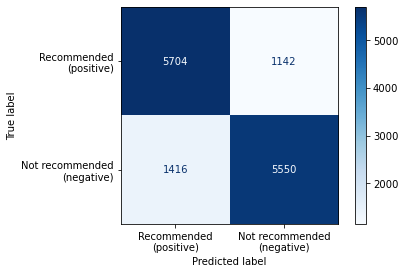

In [10]:
# Specifying class labels to show in the confusion matrix axes
classes = ['Recommended\n(positive)', 'Not recommended\n(negative)']

# Plotting confusion matrix, setting the expected estimator, inputs and target as parameters
## Displaying class labels on the axes
## Setting colour map to "Blues" to be in line with the Steam platform colour scheme throughout the project
## Passing values_format as '', otherwise it displays in scientific notation (e.g., "5878" is displayed as 5.878e3 which may be confusing for readers)
plot_confusion_matrix(mnb_gscv_best, X_test, y_test,
                      display_labels=classes,
                      cmap=plt.cm.Blues,
                      values_format = '');

As we can see from the above confusion matrix:
- **True Positive** ("TP") quadrant (top-left box): The model predicted 5,704 positive ratings which were truly positive ratings, i.e., 5,704 **accurate** predictions of **"positive"** ratings.


- **False Negative** ("FN") quadrant (top-right box): The model predicted 1,142 negative ratings which were actually positive ratings, i.e., 1,142 **inaccurate** predictions of **"negative"** ratings.


- **False Positive** ("FP") quadrant (bottom-left box): The model predicted 1,416 positive ratings which were actually negative ratings, i.e., 1,416 **inaccurate** predictions of **"positive"** ratings.


- **True Negative** ("TN") quadrant (bottom-right box): The model predicted 5,550 negative ratings which were truly negative ratings, i.e., 5,550 **accurate** predictions of **"negative"** ratings.

This is a better measure of the model's performance than accuracy score, as it paints a more in-depth picture of how many accurate and inaccurate predictions were made by the model. This paves the way to introducing 'Precision' and 'Recall' as performance measures.

## Precision

**Precision** measures the proportion of positive identifications that were actually correct.

In formulaic expression:

$$Precision = \frac{TP}{TP+FP}$$

Now, calculating the precision for our model -

In [81]:
# Importing precision score module
from sklearn.metrics import precision_score

# Calculating precision score for ML Model #3-d
print(f"Precision: {round(precision_score(y_test, y_pred)*100, 2)}%")

Precision: 82.93%


This is a great result in the sense that, of all the reviews that were predicted as positive plus the reviews that were actually positive, the model **accurately predicted the positive reviews about 83% of the time**.

## Recall

**Recall** measures the proportion of actual positives that were identified correctly.

In formulaic expression:

$$Recall = \frac{TP}{TP+FN}$$

Now, calculating the recall for our model -

In [82]:
# Recall
from sklearn.metrics import recall_score

# Calculating recall score for ML Model #3-d
print(f"Recall: {round(recall_score(y_test, y_pred)*100, 2)}%")

Recall: 79.67%


This is also a good result. This means that of all the reviews that were actually positive, **the model accurately predicted the positive reviews about 80% of the time**.

The recall score is slightly lower than the precision score. However, our project is not very sensitive to having false positives (as opposed to, say, in disease-diagnosis, where false positives can be fatal as it means that the disease would go undiagnosed and therefore untreated for some time), so this is not a big issue.

## F1-Score

The F1-score is another popular accuracy measure, which balances the precision and recall measures. F1-score is the harmonic mean of the precision and recall scores, calculated as follows:

$$F_1 = 2 \cdot \frac{precision \cdot recall}{precision + recall}$$

Now, calculating the F1-score for our model -

In [83]:
# Recall
from sklearn.metrics import f1_score

# Calculating recall score for ML Model #3-d
print(f"F1 Score: {round(f1_score(y_test, y_pred)*100, 2)}%")

F1 Score: 81.27%


This is another great result as portrayed by the harmonic mean (balance) of the precision and recall measures, signifying that the model accurately predicts the outcome of the review texts more than 81% of the time.

## ROC AUC

The Receiver Operating Characteristic (ROC) curve is formed by plotting the [true positive rate (TPR)](https://www.split.io/glossary/false-positive-rate/#:~:text=The%20true%20positive%20rate%20(TPR,as%20TN%2FTN%2BFP.) against the [false positive rate (FPR)](https://www.ibm.com/support/producthub/icpdata/docs/content/SSQNUZ_latest/wsj/model/wos-quality-fpr.html). The area under the ROC curve (AUC) is an associated metric that represents, after plotting the ROC curve, the measure of the area under the curve.

Now, calculating the ROC AUC score for our model -

In [84]:
# Recall
from sklearn.metrics import roc_auc_score

# Calculating recall score for ML Model #3-d
print(f"ROC AUC Score: {round(roc_auc_score(y_test, y_pred)*100, 2)}%")

ROC AUC Score: 81.5%


This score signifies that the model is capable of accurately distinguishing between the two outcome classes about 82% of the time; i.e., when a review text is passed through the model, it is able to accurately separate the positive-sentiment reviews from the negative-sentiment ones accurately about 82% of the time.

Now, when plotting the curve, we find the following:

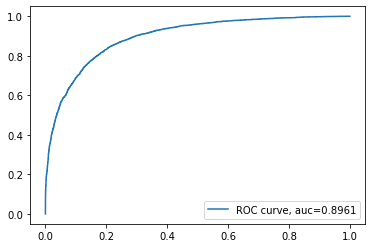

In [86]:
# Importing metrics from scikit-learn library
from sklearn import metrics

# Plotting the ROC AUC curve

## Calculating probability of predicting outcome variable classes and plotting the ROC AUC curve
y_pred_probab = mnb_gscv_best.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_probab)
auc = metrics.roc_auc_score(y_test, y_pred_probab)
plt.plot(fpr, tpr, label="ROC curve, auc="+str(round(auc,4)))
plt.legend(loc=4)
plt.show()

We see in the plot that the area under the curve is about 93%. This implies that, when the model is presented with two random reviews, one from the positive-review class and one from the negative-review class, it is more confident that the positive point belongs to the positive class than the negative point belonging to the positive class.

---
# Conclusion

We can confidently conclude that this model performed fantastically as we have observed:
- [Very high train and test accuracy scores](#Accuracy-Scores) (both over 85%)
- [Very small difference between the train and test accuracy scores](#Accuracy-Scores) (less than 2% difference between the two scores)
- Very high [precision](#Precision), [recall](#Recall), [F1](#F1-Score) as well as [ROC AUC scores](#ROC-AUC) (all above 85%)

Statistically speaking, if we had to blindly guess the class (positive/negative) for a review, we would have been expected to be correct about 50% of the time (as the dataset's class distribution is 50/50). From this standpoint, this ML model has **added significant value by adding a substantial (more than 35%) increase in accuracy** in predicting the classes based on input values.

For quick reference, the accuracy, precision, recall, and F1 scores are also summarized and tabulated below:

In [11]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[5704 1142]
 [1416 5550]]
              precision    recall  f1-score   support

           0       0.80      0.83      0.82      6846
           1       0.83      0.80      0.81      6966

    accuracy                           0.81     13812
   macro avg       0.82      0.81      0.81     13812
weighted avg       0.82      0.81      0.81     13812

0.8147987257457283


In [12]:
# Saving the best model locally for retrieval in later part of the project as needed

## Importing pickle
import pickle

## Saving the model locally
pickle.dump(mnb_gscv_best, open('model3_mnb_final.sav', 'wb'))